# SLT-CE-2: Sampling

***Legi
16-352-137***

In this coding exercise we will test various Markov Chain Monte Carlo (MCMC) sampling procedures [1] introduced during the tutorial session. We will first tackle the image reconstruction problem followed by the traveling salesman problem.

## Task (image reconstruction problem)


Given a noisy [binary image](https://en.wikipedia.org/wiki/Binary_image) one needs to recover the original through denoising. To do so we will use the prototypical [Ising model](https://en.wikipedia.org/wiki/Ising_model) from physics as explained in section 8.3.3 of [2]. An undirected graphical model is designed to model (i) the adherence of the reconstruction to the observed noisy image and (ii) the correlation between neighboring pixels. We are interested in recovering a single image, the most likely one, with respect to the underlying distribution i.e. we do MAP inference to discover the peak of the posterior distribution $p(image\_reconstruction | noisy\_observation)$.


### References 

[1] http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

[2] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

## Model

Given a noisy, binary image $y=(y_1,\dots,y_n)$ where $y_i\in\{\pm1\}$ is the value of the i-th pixel, the Ising model tries to find a denoised image $x=(x_1,\dots,x_n)$ by minimizing the following energy function:

$$E(x|y) = - \frac{\beta}{2} \sum_{i} \frac{x_i}{\lvert N_i\rvert}\sum_{j \in N_i} x_j - \mu \sum_{i} x_i y_i$$

where $N_i$ is the set of neighbors of pixel $i$. For a 2D image the pixel neighbourhood $N_i$ usually involves $\lvert N_i\rvert=$ 4 or 8 surrounding pixels. In this exercise we consider only the 4 pixel neigbourhood (up, down, left and right pixels). The undirected probabilistic graphical model from where the energy function $E(x|y)$ is derived is explained in more detail in [2].

 <h2> Setup </h2>

We start by importing necessary python packages.

In [1]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time

from skimage.transform import resize
from scipy.signal import fftconvolve
from sklearn.metrics import hamming_loss

from scipy.optimize import minimize_scalar
from multiprocessing import cpu_count
from pathos.multiprocessing import ProcessingPool as Pool

import warnings
#warnings.filterwarnings('ignore')

In [2]:
def flower(size=None, p=0.3):
    """Load image data for denoising
    
    Args:
        size (tuple): image size, default (300,300)
        p (float): noise fraction in [0,1]
        
    Returns:
        noisy: noisy image
        img: ground truth image
    """
    img = mpimg.imread("flower.png") # Load image
    
    # Binarize image
    img[img > 0.5] = 1
    img[img <= 0.5] = -1
    
    # Resize image 
    if size is not None:
        img = resize(img, size)
        img[img > 0] = 1
        img[img <= 0] = -1
    
    np.random.seed(13)

    flip = np.random.choice([-1, 1], size=img.shape, p=[p, 1-p])

    noisy = flip * img
    
    return noisy, img

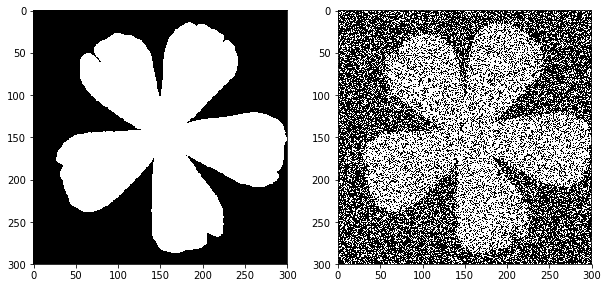

In [3]:
noisy, img = flower()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(noisy,cmap='gray')
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Shortly describe the following sampling procedures, and provide the key formulas. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Metropolis**: we assume that the proposal distribution is symmetric $(q(c'|c) = q(c|c')$ and after sampling from it we accept candidate $c'$ with the probability $A(c', c) = \min(1, \frac{p(c')}{p(c)})$ in order to fulfill detailed balance condition

- **Metropolis-Hastings**: the same as previous, but the proposal distribution can be not symmetric and then we need $A(c', c) = \min(1, \frac{p(c')q(c|c')}{p(c)q(c|c')})$

- **Simulated Annealing**: in case of Gibbs distribution $p(x)\sim e^{-\frac{E}{T}}$ changing in time (decreasing) parameter $T$ (temperature) allows to converge to the usually better final distribution, $\frac{p(c')}{p(c)} = e^{-\frac{\Delta E}{T}}$, where $\Delta E = E(c') - E(c)$ - energies (costs) of the states

<p style="background-color:#adebad;">
    Implement the energy function introduced in the model section of the notebook.<br>
    <b> (!)</b> Deliberately implement a naive solution, which explicitly performs (nested) loops to compute the sums. 
    </p>

In [28]:
def check_inside(i, di, j, dj, h, w):
    """Check if the pixel is inside the image and 4-neighborhood
    """
    i1 = i + di
    j1 = j + dj
    if (i1 >= 0) and (i1 < h) and (j1 >= 0) and (j1 < w) and (abs(di+dj) == 1):
        return True
    else:
        return False

In [29]:
def energy(img_noisy_observation, img_estimate, beta=2.5, mu=1):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the 
    observation 'img_noisy_observation', which corresponds to the vector y in the model.

    Args:
        img_estimate (np.ndarray): estimated image matrix
        img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
        energy (float): energy of the estimate given observation
    """
    height = img_estimate.shape[0]
    width = img_estimate.shape[1]
    
    E = 0
    for i in range(height):
        for j in range(width):
            E -= mu * img_estimate[i,j] * img_noisy_observation[i,j]
            sum_neighbors = 0
            n_neighbors = 0
            for di in {-1, 0, 1}:
                for dj in {-1, 0, 1}:
                    if check_inside(i, di, j, dj, height, width):
                        sum_neighbors += img_estimate[i+di, j+dj]
                        n_neighbors = 4
            E -= beta / 2.0 * img_estimate[i, j] * sum_neighbors / n_neighbors;
    
    return E 

<p style="background-color:#adebad;">Make sure to get the correct result:</p>

In [30]:
assert np.isclose(energy(*flower()), -145700.75)

<p style="background-color:#adebad;">Implement metropolis sampling.<br>
<b>(!)</b> Deliberately implement a naive solution, which loops over each pixel, attempts a flip, measures the energy before and after, and then decides whether to accept the flip, or not. Use the naive energy function from before.
</p>

In [31]:
def metropolis(img_noisy_observation, epochs, T=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using energy.

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of the simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    energies = []
    E0 = energy(noisy_img, estimate) # Current energy
    for e in range(epochs):
        
        if e == 0:
            energies.append(E0)
        
        for cnt, idx in enumerate(np.random.permutation(n_pixels)):
            
            print("Finished {:6.2f}% of epoch {}".format(cnt/n_pixels * 100, e+1), end="\r")
            
            estimate[int(idx // width), int(idx % width)] *= -1 # Swap random pixel
            E1 = energy(noisy_img, estimate) # Energy if swap
            dE = E1 - E0
            p = min(1, np.exp(-dE/T))
            rand = np.random.uniform(0, 1, 1)
            if (rand > p):
                estimate[int(idx // width), int(idx % width)] *= -1
            else:
                E0 = E1

        energies.append(E0)
       
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Evaluate your implemented metropolis algorithm, using the provided evaluation function.<br>
    The energy should decrease over epochs. The reconstructed image should be a denoised version of the noisy image.
    </p>

In [15]:
def evaluate_ising(method, img_noisy_observation, img_original, epochs=1, T=1, surpress=False):
    """ Given a sampling method, we will run the sampling procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
        method (function pointer): sampling method
        img_noisy_observation (np.ndarray): noisy image matrix
        img_original (np.ndarray): original image matrix
        epochs (int): number of epochs to run the sampling, one epoch means going through all pixels once.
        T (float): The positive temperature of the simulation
    """

    start_time = time.time()
    img_estimate, energies = method(img_noisy_observation, epochs, T)
    execution_time = time.time() - start_time

    if not surpress:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

        ax1.plot(energies, marker="x")
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('energy')

        ax2.imshow(img_estimate, cmap='gray')
        ax2.set_title('Reconstruction')
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

        ax3.imshow(img_noisy_observation, cmap='gray')
        ax3.set_title('Input')
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

        plt.suptitle("{} updates per second".format(int(img_original.size*epochs/execution_time)))

        plt.show()
    
    return energies[-1], hamming_loss(y_pred=img_estimate.flatten(), y_true=img_original.flatten())

<p style="background-color:#adebad;">
    The naive implementation is incredibly slow, so we use a downsampled image for evaluation.
</p>

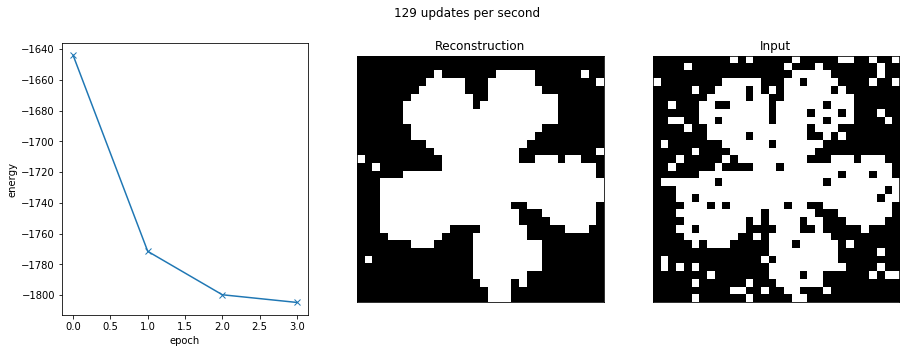

In [207]:
E_metro = evaluate_ising(metropolis, *flower(size=(32,32), p=0.1), epochs=3)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
We are now considering a different problem. We want to solve the <a href="https://en.wikipedia.org/wiki/Travelling_salesman_problem">traveling salesman problem</a> for N=532 major cities in the USA.
</p>

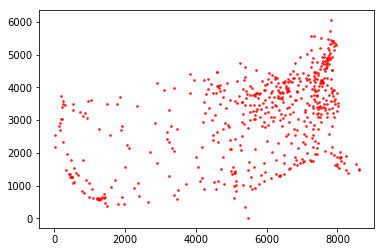

[[7810 6053]
 [7798 5709]
 [7264 5575]
 ...
 [1503  362]
 [5393  355]
 [5469   10]]


In [41]:
coordinates = pd.read_csv("cities.csv", names=['x', 'y'], sep=';', index_col=False)
coordinates = np.asarray(coordinates)  # Nx2 array containing the coordiantes of the cities
plt.scatter(coordinates[:,0], coordinates[:,1], s=3, c="r", alpha=0.75)
plt.show()
print(coordinates)

<p style="background-color:#adebad;">
Implement the distance function for the TSP:
</p>

In [3]:
def distance(coordinates, route=None):
    """Calculate travel distance.
    
    If no route is given, assumes that coordinates are travelled in order,
    starting at the first entry, and connecting the last entry again with the first.
    
    Args:
        coordinates (np.ndarray): route coordinates (assume in units of meters)
        route: permutation of coordinate order
        
    Returns:
        float: traveled distance in units of kilometers
    """
     
    if route is not None:
        coordinates = coordinates[route]
    
    dist = 0
    l = len(coordinates)
    for i in range(l):
        dist += np.sqrt((coordinates[i % l][0] - coordinates[(i+1) % l][0])**2
                      + (coordinates[i % l][1] - coordinates[(i+1) % l][1])**2)
    dist /= 1000.0
    return dist

<p style="background-color:#adebad;">
Make sure it returns the correct value:
</p>

In [136]:
assert np.isclose(distance(coordinates), 978.3514183630234)

In [4]:
def evaluate_tsp(method, coordinates, epochs=1):
    """Evaluate sampling method on coordinates
    
    Args:
        method (function pointer): sampling method
        coordinates (np.ndarray): city coordinates, shape Nx2
        epochs (int): number of epochs to run the sampling
    """
    np.random.seed(7)
    N = coordinates.shape[0]
    route = np.random.permutation(N)
 
    start_time = time.time()
    route, distances = method(coordinates, route, epochs)
    execution_time = time.time() - start_time

    if not (np.sort(route) == range(N)).all():
        raise ValueError("Returned route is not valid!")

    x, y = coordinates[route, 0], coordinates[route, 1]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.plot(distances, marker="o", markersize=3)
    plt.plot([0, len(distances)], [27686/1000,27686/1000], c="green") # best known solution
    plt.grid(axis="y")
    
    plt.subplot(122, xticks=[], yticks=[])
    plt.plot(x, y, alpha=0.5, c="blue", marker="o", markerfacecolor="red", markersize=3, linewidth=1)
    plt.plot([x[0], x[-1]], [y[0], y[-1]], alpha=0.5, c="blue", linewidth=1)
    
    plt.show()

<p style="background-color:#adebad;">
First, solve the traveling salesman problem with metropolis, and then with simulated annealing. <br>
We consider all permutations of $(1,\dots,N)$ as the solution space, so one route corresponds to one permutation. <br>
As proposals use transpositions instead of pixel flips. <br>
More precisely, pick a random index $i$, and exchange it with its successor, i.e. $(x_1,\dots,x_i, x_{i+1},\dots,x_N) \rightarrow (x_1,\dots,x_{i+1}, x_{i},\dots,x_N)$.<br>
    Keep in mind, that TSP goes in a cycle, so the successor of N is 1.
</p>

In [5]:
def dist2(ind1, ind2, route, coordinates):
    """Distance between two cities by their indices"""
    l = coordinates.shape[0]
    return 1/1000.0*np.sqrt((coordinates[route[ind1]][0] - coordinates[route[ind2]][0])**2
                 + (coordinates[route[ind1]][1] - coordinates[route[ind2]][1])**2)

In [6]:
def metropolis_tsp(coordinates, route=None, epochs=1, T=1):
    """Metropolis for TSP

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        epochs (int): number of loops through all cities.
        T (float): Temperature of simulation

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
        
    distances = []
    E0 = distance(coordinates, route)
    distances.append(E0)
    for e in range(epochs):
        
        for idx in np.random.permutation(N):
            
            # Swap change in distance
            ind0 = (idx - 1) % N
            ind1 = idx
            ind2 = (idx + 1) % N
            ind3 = (idx + 2) % N
            E1 = E0 - dist2(ind1, ind0, route, coordinates) - dist2(ind2, ind3, route, coordinates) \
                    + dist2(ind1, ind3, route, coordinates) + dist2(ind2, ind0, route, coordinates)
            dE = E1 - E0
            p = min(1, np.exp(-dE/T))
            rand = np.random.uniform(0, 1, 1)
            if (rand < p): 
                a = route[idx]
                route[idx] = route[ind2]
                route[ind2] = a
                E0 = E1
        print(E0)
        
        distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your metropolis algorithm for the traveling salesman problem.
</p>

1317.0045166567922
1284.9248248486883
1269.1425753048568
1242.4914550649212
1236.4975241636434
1201.968972605308
1210.8709761809882
1212.145368559724
1198.812394042392
1183.5176156260145
1179.073316094169
1172.1448223477905
1165.6678225840249
1152.0476814199014
1161.3886661243662
1153.8387985049587
1154.8252351009642
1137.3665209420892
1126.440493250075
1109.0511847464484
1123.0095400122946
1131.3137817418788
1127.0048731463578
1130.0132053913553
1123.9123559011969
1115.8187006159549
1116.2715593549974
1109.0909830048822
1122.4847837495413
1096.0231721151895
1100.155533484558
1114.5443386862164
1081.327698221551
1094.7578541575263
1087.3628868941107
1097.522510516481
1089.2667353201543
1088.6966303684733
1111.4458254544163
1091.5486335579867
1104.084698205432
1090.678912494132
1076.2038569788403
1086.6242329857068
1078.7734186459252
1101.6303282694953
1073.0131863747229
1076.3072985155961
1080.992728686112
1090.9130743983906
1081.967682437606
1072.880015700197
1092.8862616203653
1082.2

1030.728570353339
1012.4065691119838
1029.8816110050566
1043.4979483465695
1036.380816812789
1028.1367835866358
1046.1922888797299
1043.2133161197207
1026.5371048685709
1030.4107183221322
1023.4421025223372
1018.3953059889861
1017.9067488164736
1003.3779378202559
997.1289505750858
1010.5488676739977
1028.7360663681734
1019.5241211037865
1016.4079026258295
1015.3757562178552
1020.8360405988972
1036.3152081266462
1033.4653267933195
1031.3375844894701
1023.7128646484042
1020.9179559563785
1022.9204990133247
1015.4284069034985
1016.0911459092804
1017.9059675155813
1017.3827650000705
1041.442581265754
1027.6918636094672
1018.8591428431156
1020.6546378839638
1022.322702682393
1009.4738976118732
1016.7880567850137
991.2911440092387
1013.3673025462646
1015.0514681857499
1015.2411464232479
1027.1288017245527
989.1147052051912
1004.3725278645787
1012.7639938079179
1003.5083872422537
1006.3725040917628
999.1674844315972
1012.2616662839749
1007.0077243417927
1009.5801836226618
1013.3784354863376
9

987.7443418690771
987.5489548577033
983.7760192714726
987.3404717606682
983.8942036328766
977.6103021366099
978.0582671937709
994.56893479352
983.1099929092229
991.4555981428808
979.3457983451256
971.4571881331327
979.1730300903265
975.2330763868368
981.3914450036835
980.0751118691254
971.3303504769862
969.0399584682622
971.4898916309022
982.1711424020916
988.9996067117365
992.8779664489851
985.8167540926089
982.8085999973143
996.5231910338487
1003.0443958963176
989.9316171483961
977.1270873121
957.7674268907057
968.5885559542907
988.6129662129397
976.4773156701509
991.2656363635795
996.9817069659416
980.8605662373809
987.9798975178521
986.9756643563964
986.9831759656314
980.3503074476475
973.144126759607
976.1088689419728
969.9021478455174
994.6467196858955
981.8689537724412
995.3321737125091
988.1677741628691
1000.5103010288482
1008.4857668183895
999.7610042306683
994.1135732913145
976.0231331676114
978.1768012671669
962.6347181770454
978.5532895910452
958.6780958608268
955.492931780

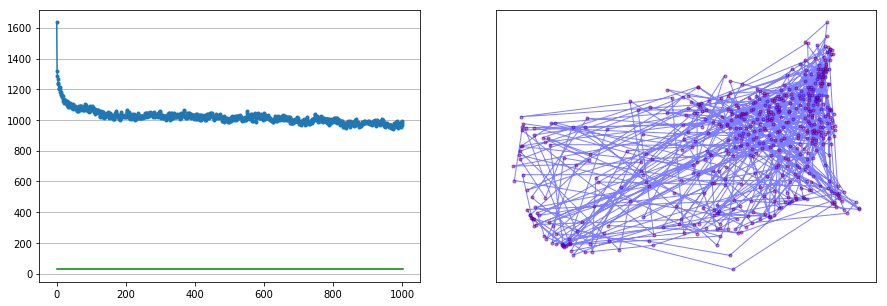

In [163]:
evaluate_tsp(metropolis_tsp, coordinates, epochs=1000)

In [166]:
def simulated_annealing(coordinates, route=None, epochs=1, T=20.0, eta=0.995):
    """Simulated Annealing for TSP

    T(n) = T * eta**n

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        route (array): inital route
        epochs (int): number of loops through all cities.
        T (float): Initial temperature
        eta (float): Exponential cooling rate

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
        
    distances = []
    E0 = distance(coordinates, route)
    distances.append(E0)
    for e in range(epochs):
        
        for idx in np.random.permutation(N):
            
            # Swap change in distance
            ind0 = (idx - 1) % N
            ind1 = idx
            ind2 = (idx + 1) % N
            ind3 = (idx + 2) % N
            E1 = E0 - dist2(ind1, ind0, route, coordinates) - dist2(ind2, ind3, route, coordinates) \
                    + dist2(ind1, ind3, route, coordinates) + dist2(ind2, ind0, route, coordinates)
            dE = E1 - E0
            T_ann = T * eta ** e 
            p = min(1, np.exp(-dE/T_ann))
            rand = np.random.uniform(0, 1, 1)
            if (rand < p): 
                a = route[idx]
                route[idx] = route[ind2]
                route[ind2] = a
                E0 = E1
        print(E0)
        
        distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your simulated annealing algorithm for the traveling salesman problem.
</p>

1558.2965644785177
1589.682013410561
1518.1132517668386
1585.884880715028
1570.2756370787345
1610.4847365947223
1557.4667290463412
1507.6573880720784
1592.3774399291842
1553.9670495196406
1513.410912107134
1585.0734642874693
1550.120939423116
1648.7712010540295
1535.712692536159
1524.3987234546107
1469.300829361527
1570.291125338926
1512.1492153866193
1547.450668976051
1504.2075146148757
1514.281751891188
1535.9727133103117
1600.8376284462427
1595.8591393659356
1608.8698521164802
1563.8916007412222
1587.107335098945
1573.3662987386276
1576.233373812785
1565.6714957237075
1551.6169064396372
1561.1029871030207
1523.8210853496646
1598.9605447095119
1495.0123190227478
1491.6138303232665
1571.113180208229
1536.982037444692
1537.4528763962608
1561.332463050686
1532.2535415636203
1640.0729739001501
1587.9722923308998
1590.0871004709857
1581.5128739051304
1578.7352819836194
1541.042686565548
1609.9373854546707
1542.4315241082127
1547.6915188684964
1584.9678735428793
1660.777161111612
1552.3440

1153.3656569920856
1147.2443359354575
1113.179694193659
1119.0638687527419
1170.8817231766473
1155.2184554219405
1154.4985764993935
1138.0756235335025
1170.644153867308
1183.5635834897266
1155.6406961618643
1115.599687383148
1115.282117212672
1146.947634620905
1135.8643421106135
1140.0711338816027
1132.192766707866
1135.8900187208417
1115.4998403297898
1115.4017750227117
1124.0131637614356
1107.9382124781712
1089.271788590895
1068.3297504191357
1089.463424915574
1095.228825425972
1087.5903481649232
1124.0832333694582
1104.3175870380785
1077.5500940201666
1101.904599651537
1089.3720371302109
1089.1640407903888
1092.9762971160544
1076.0043137844489
1066.3570169855113
1080.0995459801632
1075.7606261277977
1089.4938440925612
1085.0497886717894
1083.5830396156475
1082.9708294785228
1092.1026452608432
1070.9256588063338
1062.6733727565581
1067.0034856860445
1072.6263696068722
1054.998305089795
1069.115428694518
1062.915644619827
1036.7796956196246
1043.462263151814
1040.3185420794973
1041.08

767.8493026404111
765.5577320594986
763.6782580611488
764.9075572940442
767.2289829659534
767.9379799724472
764.9760500347498
762.2629817128917
766.8973604370144
765.456654322226
763.942178587665
760.0555295536333
761.5645442228109
762.4097840500713
760.7558393610491
762.3584011971395
762.3239744406242
760.0844535788545
763.6912506290212
761.0165001729706
759.6033183513288
762.9116316120312
760.9543755306861
763.0602776233551
761.6263545436036
759.0038536702494
762.315749469962
759.5193266590728
759.1484576439124
757.8445879834906
760.1838530225117
756.1278068568887
758.3238896800076
759.4069994324641
758.8145298236898
760.5314634879162
762.6389189198354
759.5377672675604
763.7093613484158
757.3808716209486
757.8191412192936
755.9137826986216
761.9465364421479
758.2948651026879
760.2272735004403
757.8405733510876
757.5557078155836
757.5021410167319
757.6276238958184
760.3026106466274
757.8162155057918
754.8591058555712
756.7038939103481
755.8800085984408
757.4289883893167
758.244130875

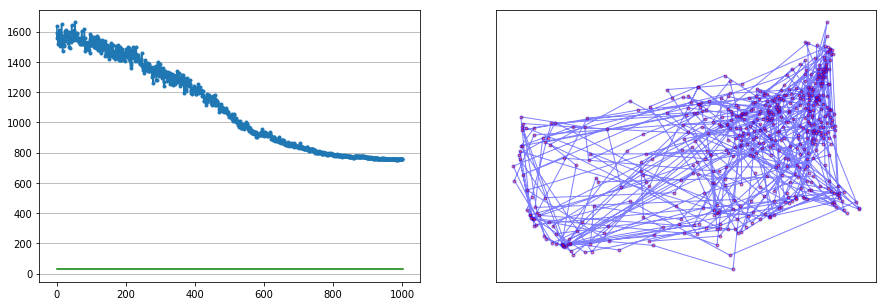

In [167]:
evaluate_tsp(simulated_annealing, coordinates, epochs=1000)

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Optimize the calculation of the naive metropolis for the Ising problem by taking into account that the energy change caused by a single flip depends only on the affected pixel's value, and its neighborhood.<br>
    More precisely, implement the function local_energy_change, and use it in the method local_metropolis.
</p>

In [231]:
def local_energy_change(noisy, estimate, i, j, beta, mu):
    """
    
    Local energy difference between unflipped and flipped pixel i,j 
    
    Args:
        noisy: noisy reference image
        estimate: current denoising estimate
        i,j: Position of pixel
    
    Returns:
        float: local energy difference when pixel i,j is flipped 
    """
    height = estimate.shape[0]
    width = estimate.shape[1]
    
    dE = 2 * mu * estimate[i,j] * noisy[i,j] # -a-a=-2a, only change itself energy
    sum_neighbors = 0
    n_neighbors = 0
    for di in {-1, 0, 1}:
        for dj in {-1, 0, 1}:
            if check_inside(i, di, j, dj, height, width):
                sum_neighbors += estimate[i+di, j+dj]
                n_neighbors = 4
    dE += 2*beta * estimate[i, j] * sum_neighbors / n_neighbors # multiply by -2 from itself and -2 from neighbors

    return dE

def local_metropolis(img_noisy_observation, epochs, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using local_energy_change 

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    energies = []
    for e in range(epochs):
        
        if e == 0:
            E0 = energy(noisy_img, estimate)
            energies.append(E0)
        
        for cnt, idx in enumerate(np.random.permutation(n_pixels)):
            i = int(idx // width)
            j = int(idx % width)
            dE = local_energy_change(img_noisy_observation, estimate, i, j, beta, mu)
            p = min(1, np.exp(-dE/T))
            rand = np.random.uniform(0, 1, 1)
            if (rand < p):
                estimate[i, j] *= -1
                E0 += dE
        
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(E0)
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    We run two evaluations, one for the small image, and one on the full image.
    </p>

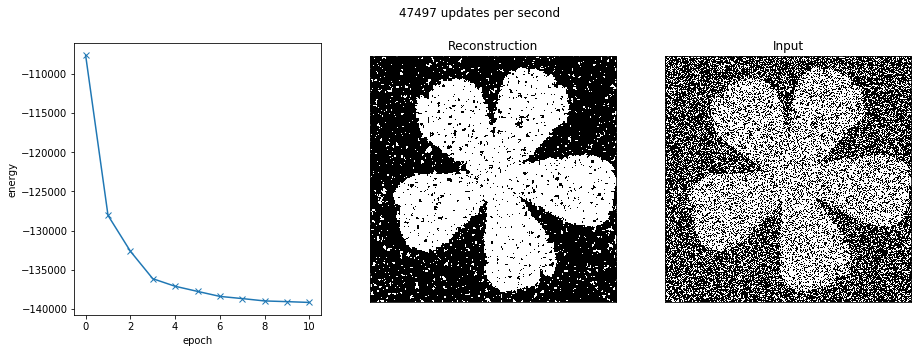

(-139178.75, 0.0736)

In [233]:
E_local = evaluate_ising(local_metropolis, *flower(size=(32,32), p=0.1), epochs=3, surpress=True);
evaluate_ising(local_metropolis, *flower(), epochs=10)

<p style="background-color:#adebad;">
    Make sure, metropolis and local_metropolis are equivalent:
    </p>

In [234]:
assert E_metro == E_local

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    We can speed up metropolis for the Ising model even further by using vectorized operations, i.e. using operations on arrays instead of looping over pixels.<br>
    Implement checkerboard_metropolis, which alternatingly updates two independent sub-grids at once.
    Your final code must have only one for-loop, namely over epochs (not counting the loop over the two grids). Use fftconvolve to compute the neighborhood term of the energy difference.
    </p>

In [23]:
def checkerboard_energy_change(noisy_img, estimate, grid, beta, mu):
    """Compute energy change when flipping pixels in grid
    
    When using the 4-neighborhood, a 2D image can be separated in two
    independent grids, hence the name checkerboard.
    All the pixels in one grid can be updated simultaneously, because they
    are independent. Using this property, we can improve computational
    efficiency by using vectorized operations instead of loops.
    
    Args:
        noisy_img: Noisy reference image
        estimate: Current image reconstruction
        grid: Flat array or list of grid indices.
    
    Returns:
        numpy.array: Energy change for each pixel in grid,
            same size as grid.
    
    """
    
    de = estimate*noisy_img*2*mu
    de = de + estimate*fftconvolve(beta*estimate, [[0, 1, 0], [1, 0, 1], [0, 1, 0]], mode='same')
    de = de*grid
    return de

In [20]:
noisy_img, estimate = flower()
mu = 1
beta = 1
de = np.ones((3,3))
grid = [[1,0,0], [0,1,0], [0,0,0]]
print(de*grid)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]


In [35]:
def checkerboard_metropolis(img_noisy_observation, epochs=1, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    Alternatingly update two independent grids

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number

    n_pixels = img_noisy_observation.size
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    #
    #
    # Your turn, definition of grids
    grid0 = np.zeros_like(estimate)
    grid1 = np.zeros_like(estimate)
    for i in range(estimate.shape[0]):
        for j in range(estimate.shape[1]):
            if ((i + j) % 2):
                grid0[i, j] = 1
            else:
                grid1[i, j] = 1\
                
    grids = (grid0, grid1)            
    
    energies = []
    for e in range(epochs):

        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for grid in grids:
            # Your turn
            dE = checkerboard_energy_change(noisy_img, estimate, grid, beta, mu)
            p = np.minimum(1, np.exp(-dE/T)*grid)
            rand = np.random.uniform(0, 1, estimate.shape)
            estimate[rand < p] *= -1
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Run the checkerboard_metropolis:
    </p>

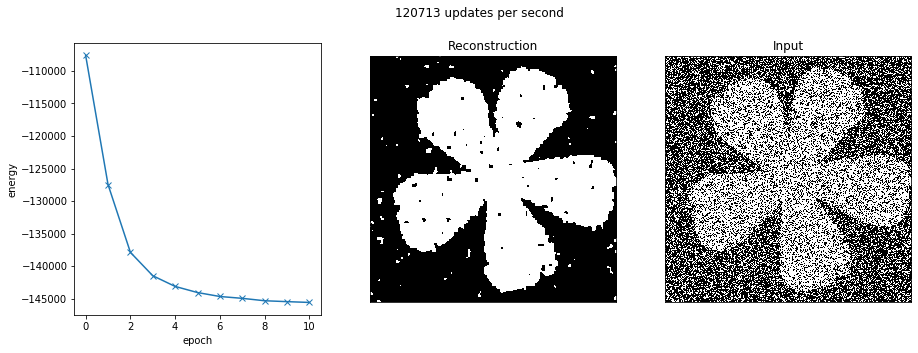

(-145567.25, 0.02798888888888889)

In [36]:
evaluate_ising(checkerboard_metropolis, *flower(), epochs=10)

<p style="background-color:#adebad;">
    Run the experiment below, and explain the observed behavior!
    </p>

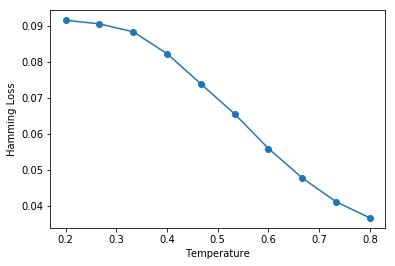

In [37]:
Trange = np.linspace(0.2,0.8,10)
loss = [evaluate_ising(checkerboard_metropolis, *flower(), epochs=10, T=T, surpress=True)[1]
         for T in np.linspace(0.2,0.8,10)]

plt.plot(Trange, loss, marker="o")
plt.ylabel("Hamming Loss")
plt.xlabel("Temperature")
plt.show()

Bigger temperature means that cells tend to change their value more freely and therefore after not much epochs solution could be better than for smaller temperatures (though with the further increase of temperature amount of the "heat clutter" will increase loss => there is some minimum in-between

<p style="background-color:#adebad;">
Run the experiment below, and explain the observed behavior!
</p>

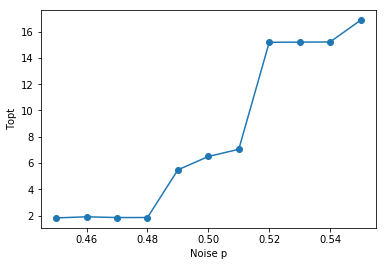

Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/multiprocess/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/multiprocess/process.py", line 252, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/multiprocess/process.py", line 252, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/multiprocess/process.py", line 252, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/envs/slt-ce/lib/python3.5/si

  File "/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/multiprocess/connection.py", line 382, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [38]:
def find_Topt(p):
    f = lambda T: evaluate_ising(checkerboard_metropolis, *flower(p=p), epochs=10, T=T, surpress=True)[1]
    result = minimize_scalar(f, options={"xatol": 0.001}, bounds=(0, 20), method="bounded")
    return result.x

prange = np.arange(0.45, 0.55, 0.01)
with Pool(cpu_count()) as pool:
    Topt = pool.map(find_Topt, prange)
    
plt.plot(prange, Topt, marker="o")
plt.ylabel("Topt")
plt.xlabel("Noise p")
plt.show()

The more is noise, the more should be the optimal temperature in order to effectively escape from introduced by noise suboptimal pseudostructures (minima) and find the real one

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Implement a more sophisticated proposal distribution, which is more appropriate for TSP than simple transpositions. <br>
Consider your idea successful, if the travel distance goes at least below 300.<br>
Moreover, make sure that your algorithm fullfills detailed balanced by using the Metropolis-Hastings acceptance probability:<br>
    $p_{accept}=\min(\frac{p(x\rightarrow y)}{p(y\rightarrow x)}e^{-\frac{\Delta E}{T}}$, 1)
</p>

We propose to swap random pair of cities. Obviously, induced MC is irreducible, as we can result in any possible order of cities with these swaps, and aperiodic, as we can stay with non-zero probability (first we uniformly random choose the first city and then from sequence (-N//2, ..., -1, 0, 0, 1, ..., N//2) we choose shift of the second city in the swapping pair

We fulfill MH acceptance probability condition by choosing the first city randomly from the whole set and 
then choosing offset to the city to swap which is symmetric, so it means $p(x\rightarrow y) = p(y\rightarrow x)$ and we can use $p_{accept} = min(1, e^{-\frac{\Delta E}{T}})$ for all proposed transitions (actually, its Metropolis algorithm)

We calculate $\Delta E$ as the change in distances between proposed to swap cities and their neighbors, that makes algorithm's work much faster

Also, we precalculate distances between cities in the matrix $\texttt{dist_matrix}$

In [11]:
coordinates = pd.read_csv("cities.csv", names=['x', 'y'], sep=';', index_col=False)
coordinates = np.asarray(coordinates)  # Nx2 array containing the coordiantes of the cities

In [12]:
dist_matrix = np.zeros((coordinates.shape[0], coordinates.shape[0]))
for i in range(coordinates.shape[0]):
    for j in range(coordinates.shape[0]):
        dist_matrix[i, j] = 1/1000.0*np.sqrt((coordinates[i][0] - coordinates[j][0])**2\
                     + (coordinates[i][1] - coordinates[j][1])**2)

In [ ]:
def myfancyalgorithm(coordinates, route=None, epochs=1, Temp=10, eta=0.95):
    
    np.random.seed(7)
    
    T0 = Temp
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
        
    distances = []
    E0 = distance(coordinates, route)
    distances.append(E0)
    
    for e in range(epochs):
        for i in range(N):
            indx = np.random.randint(0, N)
            d = np.random.randint(0, N//2) # prob of staying unchanged is 2 / (N // 2 - 1) != 0 => aperiodic
            sign = np.random.randint(0,2) 
            d *= int(2*(sign-0.5))

            # Swap change in distance
            ind0 = (indx - 1) % N
            indx = indx
            ind1 = (indx + 1) % N
            ind2 = (indx + d - 1) % N
            ind3 = (indx + d) % N
            ind4 = (indx + d + 1) % N
            
            # consider different cases of swapping
            if (d == 0):
                dE = 0
            elif (d == 1 or d == 2):
                dE = - dist_matrix[route[ind0], route[indx]] - dist_matrix[route[ind3], route[ind4]]\
                     + dist_matrix[route[ind0], route[ind3]] + dist_matrix[route[indx], route[ind4]]
            elif (d == -1 or d == -2):
                dE = - dist_matrix[route[ind1], route[indx]] - dist_matrix[route[ind3], route[ind2]]\
                     + dist_matrix[route[ind1], route[ind3]] + dist_matrix[route[indx], route[ind2]]
            else:
                dE = - dist_matrix[route[ind0], route[indx]] - dist_matrix[route[indx], route[ind1]]\
                     - dist_matrix[route[ind3], route[ind2]] - dist_matrix[route[ind3], route[ind4]]\
                     + dist_matrix[route[indx], route[ind2]] + dist_matrix[route[indx], route[ind4]]\
                     + dist_matrix[route[ind0], route[ind3]] + dist_matrix[route[ind1], route[ind3]]
            #print(dE)
            sim_ann = False
            if (sim_ann):
                T = T0*eta**e
            else:
                T = T0
            p = min(1, np.exp(-dE/T))
            rand = np.random.uniform(0, 1, 1)
            if (rand < p): 
                a = route[indx]
                route[indx] = route[ind3]
                route[ind3] = a
                E0 += dE     
        distances.append(E0)
    print(E0)
    return np.asarray(route), np.asarray(distances) 

<p style="background-color:#adebad;">
Evaluate your more sophisticated algorithm for the traveling salesman problem.
</p>

Using simulated annealing (decreasing T)

225.2743245984856


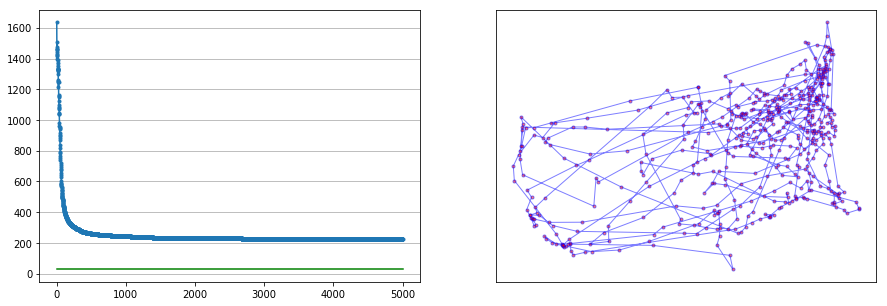

In [28]:
evaluate_tsp(myfancyalgorithm, coordinates, epochs=5000)

Without simulated annealing(constant T)

225.2743245984856


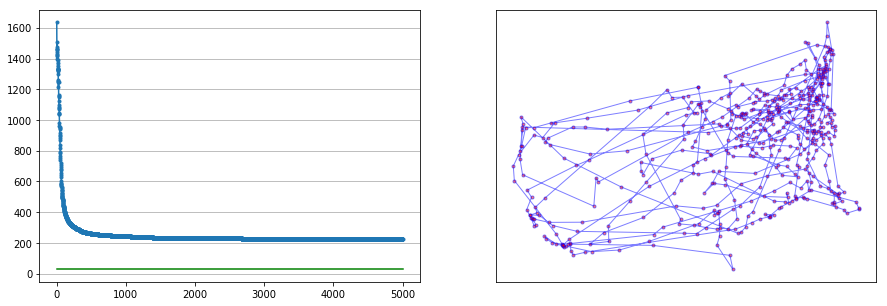

In [30]:
evaluate_tsp(myfancyalgorithm, coordinates, epochs=5000)

Using our distribution we observe convergence with distance $\approx 225$, it doesn't depend on type (simulated annealing or usual, stucks in the same distribution in the end) 

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.